# AI Discourse Final Project

This is the annotated code file for Jacy's final project for SOCI 40133 Winter 2021. The corpus is 72,951 articles from News on the Web (NOW) that mention artificial intelligence. I primarily use techniques from Weeks 1, 2, 6, 7, and 8.

In [1]:
#Class package
import lucem_illud as lucem_illud_2020 #pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Cleaning and processing packages
import re
import os
import zipfile
import time
import datetime
import random
import nltk

#General data analysis and visualization packages
import pandas as pd
import numpy as np
import spacy
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
#command to make plots work better in Jupyter Notebook
%matplotlib inline

#Machine learning packages
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

#Topic modeling and word embedding package
import gensim

#Deep learning packages
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
from keras.preprocessing.sequence import pad_sequences

#Set keras to tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

#Load 'en' model
nlp = spacy.load('en_core_web_sm')

#Set local directory for DataFrame and models
aiDir = 'C://NOW/'

#Set RCC directory for loading NOW corpus
rccDir = '/project2/jevans/Davies_corpora/NOW'

## Convert NOW .txt files into Pandas DataFrame and clean
Note this code is meant to be ran on the RCC; the DropBox NOW corpus is more limited.

In [ ]:
#Define a function to iterate through files in the target directory that start with 'text'
#These are fixed-width files with two attributes, id and text, which get loaded into a DF.
def loadcorpus(targetdir,endpoint=False):
    break_flag = False
    texts = pd.DataFrame()
    for file1 in os.listdir(targetdir):
        file1name = os.fsdecode(file1)
        if file1name.startswith('text'):
            zfile = zipfile.ZipFile(targetdir + '/' + file1)
            for file2 in zfile.namelist():
                file2name = os.fsdecode(file2)
                #optional endpoint if you only want a portion of the NOW corpus
                if file2name == endpoint:
                    break_flag = True
                    break
                print(file2name)
                data = pd.read_fwf(zfile.open(f'{file2name}'),colspecs=[(2,10),(11,None)],encoding='utf-8',names=['id','text'])
                texts = texts.append(data,ignore_index=True)
        if break_flag == True:
            break
    return texts

In [ ]:
#Run the function
texts = loadcorpus(rccDir)

In [ ]:
#Some entries are missing the initial < in their HTML. Add one if it's not already there.
df['text'] = df['text'].apply(lambda x: '<' + x if not x.startswith('<') else x)

In [ ]:
#Filter for news articles that mention AI, DL, or ML.
aiTexts = texts[texts.text.str.contains("artificial intelligence|deep learning|machine learning",na=False)]

In [ ]:
#Define a similar function for metadata.
#These are tab-delimited files. The encoding is messy, but using latin1 and the python engine gets most of the files.
#In the future, it would be nice to sort the files by encoding and create a more complete corpus.
def loadmetadata(targetdir):
    metadata = pd.DataFrame()
    for file1 in os.listdir(targetdir):
        file1name = os.fsdecode(file1)
        print(file1name)
        if file1name.startswith('now_sources') or file1name.startswith('sources'):
            zfile = zipfile.ZipFile(targetdir + '/' + file1)
            for file2 in zfile.namelist():
                file2name = os.fsdecode(file2)
                #I didn't put a break point in this function yet.
                print(file2name)
                data = pd.read_csv(zfile.open(f'{file2name}'),sep='\t',error_bad_lines=False,engine='python',encoding='latin1',names=['id','length','date','country','publisher','url','title'])
                metadata = metadata.append(data,ignore_index=True)
    return metadata

In [ ]:
#Run the function
metadata = loadmetadata(rccDir)

In [ ]:
#Add in date variables for future use.
metadata['year'] = pd.to_numeric(metadata.date.str[:2])
metadata['month'] = pd.to_numeric(metadata.date.str[3:5])
metadata['day'] = pd.to_numeric(metadata.date.str[6:8])

In [ ]:
#Merge the DFs with an inner join on id (i.e. only news articles for which there is text and metadata)
df = pd.merge(metadata,texts,on='id',how='inner')

In [ ]:
#Create a CSV of the corpus
#df.to_csv('aiTexts.csv')

## Add tokens and pickle the DF
Various tokens (e.g. normalized word tokens, tokenized sentences) are used in the analysis. Text features that are lists (e.g. lists of tokens) are easier to store and read as a pickled DataFrame than as a CSV.

In [ ]:
df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))

In [ ]:
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [ ]:
df['tokenized_sents'] = df['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])


In [ ]:
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [ ]:
#Reduced tokens require a vocabulary list first, so this cell will not work without the aiTFVectorizer
aiTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
aiTFVectorizer.fit_transform(df['text'])

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

df['reduced_tokens'] = df['normalized_tokens'].apply(lambda x: dropMissing(x, aiTFVectorizer.vocabulary_.keys()))

In [ ]:
df.to_pickle(aiDir + 'aiTextsWithTokens.df')

## Load the pickled DF

In [2]:
#To keep from running the above cells repeatedly, just load the df to use henceforth.
df = pd.read_pickle(aiDir + 'aiTextsWithTokens.df')
df

,id,length,date,country,publisher,url,title,text,tokenized_text,normalized_tokens,reduced_tokens,year,month,day,tokenized_sents,normalized_sents
0,1336549,984.0,10-01-04,US,Project Syndicate,http://www.project-syndicate.org/commentary/gr...,Grandmasters and Global Growth,"<p> Kenneth Rogoff , Professor of Economics an...","[<, p, >, Kenneth, Rogoff, Professor, of, Econ...","[<, p, >, kenneth, rogoff, professor, economic...","[professor, public, policy, university, bank, ...",10,1,4,"[[<, p], [>], [Kenneth, Rogoff, Professor, of,...","[[<, p], [>], [kenneth, rogoff, professor, eco..."
1,1336930,958.0,10-01-04,GB,HiddenWires,http://hiddenwires.co.uk/resourcesarticles2010...,The Hydra Project - Middleware for Easy Networ...,<p> Networked sensors and devices have huge po...,"[<, p, >, Networked, sensors, and, devices, ha...","[<, p, >, network, sensor, device, huge, poten...","[network, device, huge, potential, ensure, dif...",10,1,4,"[[<, p, >], [Networked, sensors, and, devices,...","[[<, p, >], [networked, sensors, devices, huge..."
2,1338856,4781.0,10-01-06,US,Westword,http://www.westword.com/news/lego-universe-col...,LEGO Universe - colorful plastic's answer to W...,<h> LEGO Universe ? colorful plastic 's answer...,"[<, h, >, LEGO, Universe, colorful, plastic', ...","[<, h, >, lego, universe, colorful, plastic, a...","[answer, base, black, way, form, little, build...",10,1,6,"[[<, h], [>, LEGO, Universe], [colorful, plast...","[[<, h], [>, lego, universe], [colorful, plast..."
3,1340445,1569.0,10-01-07,US,Popular Science,http://www.popsci.com/gadgets/article/2010-01/...,Exclusive: Inside Project Natal's Brain,<h> Exclusive : Inside Project Natal 's Brain ...,"[<, h, >, Exclusive, Inside, Project, Natal', ...","[<, h, >, exclusive, inside, project, natal, b...","[project, brain, project, let, control, game, ...",10,1,7,"[[<, h], [>], [Exclusive], [Inside, Project, N...","[[<, h], [>], [exclusive], [inside, project, n..."
4,1342810,280.0,10-01-09,US,PC Magazine,"http://www.pcmag.com/article2/0,2817,2357928,0...",Roxxxy the 'Sex Robot' Debuts at AVN Porn Show,<h> Roxxxy the ' Sex Robot ' Debuts at AVN Por...,"[<, h, >, Roxxxy, the, Sex, Robot, Debuts, at,...","[<, h, >, roxxxy, sex, robot, debut, avn, porn...","[robot, robot, robot, meet, engine, programme,...",10,1,9,"[[<, h], [>], [Roxxxy], [the, Sex, Robot, Debu...","[[<, h], [>], [roxxxy], [sex, robot, debuts, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72946,62224699,636.0,20-10-31,ZA,capetownetc.com,https://www.capetownetc.com/news/4ir-commissio...,4IR commission recommends radical changes to e...,<p> President Cyril Ramaphosa 's 4IR commissio...,"[<, p, >, President, Cyril, Ramaphosa', ""'s"", ...","[<, p, >, president, cyril, ramaphosa, 4ir, co...","[president, commission, release, statement, we...",20,10,31,"[[<, p, >, President, Cyril, Ramaphosa, 's, 4I...","[[<, p, >, president, cyril, ramaphosa, 4ir, c..."
72947,62224797,457.0,20-10-31,ZA,2oceansvibe.com,https://www.2oceansvibe.com/2020/10/30/how-sas...,"How SA's New `Buy Now, Pay Later' Business Mod...",<p> While it might seem like a good idea to pa...,"[<, p, >, While, it, might, seem, like, a, goo...","[<, p, >, like, good, idea, pay, credit, cours...","[good, idea, pay, credit, course, month, year,...",20,10,31,"[[<, p], [>, While, it, might, seem, like, a, ...","[[<, p], [>, like, good, idea, pay, credit, co..."
72948,62224321,649.0,20-10-31,ZA,themediaonline.co.za,https://themediaonline.co.za/2020/10/nothing-s...,Wavemaker's new bespoke OS delivers 'provocati...,<h> Wavemaker 's new bespoke OS delivers ' pro...,"[<, h, >, Wavemaker', ""'s"", 'new, bespoke, OS,...","[<, h, >, wavemaker, new, bespeak, os, deliver...","[deliver, plan, launch, news, different, point...",20,10,31,"[[<, h], [>], [Wavemaker, 's, new, bespoke, OS...","[[<, h], [>], [wavemaker, new, bespoke, os, de..."
72949,52056036,547.0,20-10-31,NG,independent.ng,https://www.independent.ng/the-increasing-infl...,The Incr

In [3]:
#Set random seed and create a small sample of the 72,951 articles for computationally intensive analysis.
seed = 123
sample = df.sample(500,random_state=seed)
sample

,id,length,date,country,publisher,url,title,text,tokenized_text,normalized_tokens,reduced_tokens,year,month,day,tokenized_sents,normalized_sents
13598,19600955,1257.0,17-07-21,ZA,Independent Online,http://www.iol.co.za/business-report/opinion--...,"OPINION : Yes, AI is when a computer now think...","<h> OPINION : Yes , AI is when a computer now ...","[<, h, >, OPINION, Yes, AI, is, when, a, compu...","[<, h, >, opinion, yes, have, computer, think,...","[computer, think, south, african, happen, spen...",17,7,21,"[[<, h], [>, OPINION], [Yes, AI, is, when, a, ...","[[<, h], [>, opinion], [yes, ai, computer, thi..."
23087,25114660,509.0,18-06-11,BD,Prothom Alo English (satire) (press release) (...,http://en.prothomalo.com/international/news/17...,US slaps sanctions on Russia hacking,<h> London Named AI ( Artificial Intelligence ...,"[<, h, >, London, Named, AI, Artificial, Intel...","[<, h, >, london, name, have, artificial, inte...","[london, capital, europe, london, capital, eur...",18,6,11,"[[<, h], [>], [London, Named, AI, Artificial, ...","[[<, h], [>], [london, named, ai, artificial, ..."
31742,40636904,148.0,19-02-19,MY,The Star Online,https://www.thestar.com.my/tech/tech-news/2019...,Facebook's AI chief researching new breed of s...,<h> Facebook 's AI chief researching new breed...,"[<, h, >, Facebook', ""'s"", 'AI, chief, researc...","[<, h, >, facebook, have, chief, research, new...","[facebook, chief, research, say, moment, remai...",19,2,19,"[[<, h], [>, Facebook, 's, AI, chief, research...","[[<, h], [>, facebook, ai, chief, researching,..."
45538,81555930,487.0,19-10-11,??,Security,https://www.securityinfowatch.com/video-survei...,DW Spectrum IPVMS v4.0,"<h> DW Spectrum IPVMS v4.0 <p> Cerritos , CA (...","[<, h, >, DW, Spectrum, IPVMS, v4.0, <, p, >, ...","[<, h, >, dw, spectrum, ipvms, v4.0, <, p, >, ...","[october, digital, industry, leader, digital, ...",19,10,11,"[[<, h], [>, DW, Spectrum, IPVMS], [v4.0, <, p...","[[<, h], [>, dw, spectrum, ipvms], [v4.0, <, p..."
573,1171111,3585.0,12-10-07,AU,The Australian Financial Review,http://www.afr.com/technology/female-tech-lead...,Female tech leaders solving the family conundrum,<h> Female tech leaders solving the family con...,"[<, h, >, Female, tech, leaders, solving, the,...","[<, h, >, female, tech, leader, solve, family,...","[tech, leader, solve, family, single, problem,...",12,10,7,"[[<, h], [>, Female, tech, leaders, solving, t...","[[<, h], [>, female, tech, leaders, solving, f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34458,70657074,246.0,19-04-05,US,Engadget,https://www.engadget.com/2019/04/05/apple-goog...,Apple lures another of Google's top experts to...,<h> Apple lures another of Google 's top exper...,"[<, h, >, Apple, lures, another, of, Google', ...","[<, h, >, apple, lure, google, expert, have, t...","[apple, google, team, image, apple, senior, vi...",19,4,5,"[[<, h], [>, Apple, lures, another, of, Google...","[[<, h], [>, apple, lures, google, experts, ai..."
31750,40638229,1844.0,19-02-19,SG,Yahoo News,https://sg.news.yahoo.com/canada-poised-play-c...,Canada poised to play critical role on future ...,<p> They described the Canadian astronaut as u...,"[<, p, >, They, described, the, Canadian, astr...","[<, p, >, describe, canadian, astronaut, uniqu...","[position, medical, spend, space, total, nearl...",19,2,19,"[[<, p], [>], [They, described, the, Canadian,...","[[<, p], [>], [described, canadian, astronaut,..."
1751,3582895,1535.0,15-09-11,GB,MinuteHack,http://minutehack.com/opinions/how-the-interne...,How The Internet Of Things Will Improve The Fu...,<h> How The Internet Of Things Will Improve Th...,"[<, h, >, How, The, Internet, Of, Things, Will...","[<, h, >, internet, thing, improve, future, <,...","[internet, thing, improve, future, internet, t...",15,9,11,"[[<, h], [>], [How, The, Internet, Of, Things,...","[[<, h], [>], [internet, things, improve, futu..."
30576,60500213,333.0,19-02-01,IE,BreakingNews.ie,https:/

## Let's get an initial sense of the corpus

In [4]:
df['year'].value_counts()

20    21255
19    21137
18    13478
17     8466
16     6335
15      831
14      719
11      310
12      186
10      149
13       85
Name: year, dtype: int64

We see many more later articles. Note this is partly an increase in usages of "artificial intelligence,"
but the NOW corpus overall has many more articles in later years. See the following:

In [22]:
metadata['year'].value_counts()

19    3701270
20    3595057
17    3351724
16    3306504
18    2935419
15     816401
14     639858
13     579269
12     524738
11     431989
10     343326
Name: year, dtype: int64

In [10]:
#What about publishers?
df['publisher'].value_counts()[:20]

analyticsindiamag.com              1712
Digital Journal                     776
The Straits Times                   770
Times of India                      621
Forbes                              562
TMCnet                              559
Livemint                            506
YAHOO!                              499
Business Insider                    482
DEALSTREETASIA                      460
itweb.co.za                         438
The Australian Financial Review     432
NEWSTAGE                            421
AsiaOne                             420
ITWeb                               381
The Star Online                     374
yourstory.com                       362
it-online.co.za                     360
PR Newswire                         359
The Business Times                  353
Name: publisher, dtype: int64

In [8]:
#What about countries?
df['country'].value_counts()

US    15875
IN     8896
SG     8032
GB     5788
CA     5719
ZA     5049
AU     4935
IE     4692
NZ     2601
MY     2200
??     1985
NG     1896
PH     1309
PK     1194
HK     1100
KE      547
GH      375
LK      306
BD      235
?        98
TZ       82
JM       30
y         4
          3
Name: country, dtype: int64

It looks like quite a few US, India, and Singapore articles, either in generic or business media outlets. I actually didn't realize just how business-focused the corpus is, as further evidenced in the rest of this analysis.

In [22]:
#What do these articles tend to look like?
for i in range(0,10):
    print(f'ARTICLE {i}:')
    print(f'TITLE: {sample["title"].iloc[i]}')
    print(sample['text'].iloc[i][:400])

ARTICLE 0:
TITLE: OPINION : Yes, AI is when a computer now thinks for itself
<h> OPINION : Yes , AI is when a computer now thinks for itself <p> SO , there 's this South African mate of mine who happens to be a gifted polymath . He is a media-shy physics PhD who spent much of his early professional career working in finance - programming artificial intelligence ( AI ) driven solutions to take over complex portfolio management tasks that were traditionally handled by human 
ARTICLE 1:
TITLE: US slaps sanctions on Russia hacking
<h> London Named AI ( Artificial Intelligence ) Capital of Europe <p> London ? is the Artificial Intelligence ( AI ) capital of ? Europe , home to double the number of AI companies* than closest rivals ? Paris ? and ? Berlin ? combined . <p> That is the key finding of a major piece of research commissioned by the Mayor of ? London , ? Sadiq Khan , that for the first time maps the capital 's AI eco
ARTICLE 2:
TITLE: Facebook's AI chief researching new breed of sem

It looks like a variety of business articles, either directly related to AI (e.g. "AI is when a computer now thinks for itself") or indirectly (e.g. "US slaps sanctions on Russia hacking").

Also, some of the articles are quite messy. For example, they include non-article text such as legal boilerplate (e.g. "The MarketWatch News Department was not involved in the creation of this content"). After finishing this project, I plan to run the same code on a dataset of ProQuest news articles, which may be cleaner.

So in what context is the phrase "artificial intelligence" used in these articles?

In [39]:
test_string = ' '.join(sample['text'][:250].apply(str))

In [40]:
aiTokens = lucem_illud_2020.word_tokenize(test_string)

In [41]:
aiText = nltk.Text(aiTokens)

aiIndex = nltk.text.ConcordanceIndex(aiText) 
aiIndex.print_concordance('artificial')

Displaying 25 of 257 matches:
eer working in finance programming artificial intelligence AI driven solutions t
ture economy and society more than artificial intelligence < p > The research de
pin most of the recent progress in artificial intelligence would need to be able
puter science with a speciality in artificial intelligence and is so intense in 
osts on emerging technologies like artificial intelligence machine learning data
unt shares images of topics around artificial intelligence computer vision deep 
ic cars save humanity from runaway artificial intelligence smoke weed on live TV
shes It can combine both human and artificial intelligence to sort through the c
romote advancement in the field of artificial intelligence and related areas < p
 But more than a cool way of using artificial intelligence AI to teach students 
 can be particularly vulnerable to artificial manipulation like being able to lo
ta bringing forward the promise of artificial intelligence for integration of d

In [42]:
aiText.common_contexts(['artificial'])

of_intelligence and_intelligence in_intelligence on_intelligence
use_intelligence >_intelligence using_intelligence with_intelligence
uses_intelligence by_intelligence like_intelligence to_intelligence
an_intelligence through_intelligence as_intelligence
based_intelligence ai_intelligence the_intelligence 's_intelligence
than_intelligence


In [43]:
aiText.count('artificial')

257

Some finance, some economics, some healthcare, some big data, some augmented reality. Mostly what we would expect.

What words are more common?

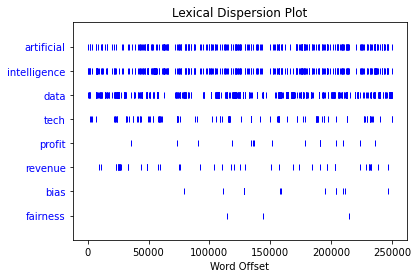

In [44]:
sns.reset_orig()
aiText.dispersion_plot(['artificial','intelligence', 'data', 'tech', 'profit', 'revenue', 'bias', 'fairness'])
sns.set()

Discussions of bias and fairness do not seem very common. This is only a small subset of the corpus, but when I saw this in Week 2, it indicated that the overall topic models, word embeddings, transformers, etc. will not be very focused on the deep social questions around AI.

Now, let's count the number of keywords per year and graph them to get a sense of discursive change from 2010 to 2020.

In [46]:
years = list(range(10,21))

countsDF = pd.DataFrame({
}, index=years)

keywords = ['profit','revenue','bias','fairness']

for keyword in keywords:
    countsDF[keyword] = 0

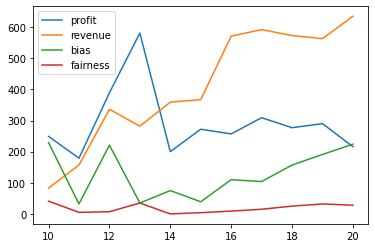

In [49]:
for year in range(10,21):
    texts = [element for list_ in df['normalized_tokens'][df['year'] == year].values for element in list_]
    for text in texts:
        for keyword in keywords:
            if text == keyword:
                countsDF[keyword].at[year] += 1
    #Adjust for number of words per year because NOW oversamples later years.
    for keyword in keywords:
        if countsDF[keyword].at[year] != 0:
            countsDF[keyword].at[year] /= len(texts)/1000000 #large denominator to avoid values rounding down to 0

lines = countsDF.plot.line()

In [50]:
#These are relative counts.
countsDF

,profit,revenue,bias,fairness
10,249,83,229,41
11,179,157,32,5
12,389,336,221,7
13,581,282,35,35
14,200,359,75,0
15,272,367,39,4
16,257,571,110,9
17,309,592,104,15
18,277,573,157,25
19,290,563,191,32


There is probably a lot of noise, but we see:

- "profit" peaks in 2013
- "revenue" gets much more attention in later years
- "bias" has a spike in 2012 and takes off in 2019 and 2020
- "fairness" stays fairly low throughout

What can we learn from revisiting the texts? Well, to pick some 2012 articles that mention "bias"...

In [100]:
bias2012 = df[df.text.str.contains('bias') & (df.year == 12)]

for index, row in bias2012[:10].iterrows():
    print(f'\nTITLE: {row["title"]}')
    print([s for s in row['text'].split('.') if 'bias' in s])


TITLE: The Future of Corporate Responsibility
[' Narrowly biased , reactionary responses to the complex disruptive forces emerging and being given voice in the information revolution are very likely ', ' " <p> Other overarching thoughts <p> These scenarios completely neglect other significant influences , @ @ @ @ @ @ @ @ @ @ participant observed , " There is a Western bias/shortsightedness in this question ']

TITLE: The Future of Big Data
[' " Coupled with the data , though , we must have a much better understanding of decision making , which means extending knowledge about cognitive biases , about boundary work ( scientists , citizens , and policymakers working together to weigh options on the basis not only of empirical evidence but also of values ) ', ' @ @ @ @ @ @ @ @ @ @ is biased and missing context , as it \'s based on convenience samples or subsets , " said Dan Ness , principal research analyst at MetaFacts ']

TITLE: Asking the right questions: big data and civil rights
[' N

These are all relevant uses of bias, but only one article (by Anders Sandberg, an Oxford futurist whom I've spoken with a few times) seems to be specifically about the bias of AI.

In [99]:
bias2020 = df[df.text.str.contains('bias') & (df.year == 20)]

for index, row in bias2020[:10].iterrows():
    print(f'\nTITLE: {row["title"]}')
    print([s for s in row['text'].split('.') if 'bias' in s])


TITLE: Fight against facial recognition hits wall across the West ...
[' Current implementations of the software also perpetuate racial bias by misidentifying people of color far more frequently than white people , according to a U']

TITLE: Will Carolyn Wilkins be the next head <strong>of</strong> the Bank <strong>of</strong> ...
[' <p> Tobias L ? tke , CEO , Shopify Inc', " But if founder-CEO Tobias L ? tke ca n't post some profits soon , investor zeal for Shopify -- whose stock has more than doubled in the past year , to $487 per share -- @ @ @ @ @ @ @ @ @ @ The number of merchants using its online merchandising tools ( inventory control , sales analytics , marketing ) soared by 66 per cent this year to cross the 1 million mark "]

TITLE: The Climate Scientists got it wrong. - Page 2 - The ...
[" Of course panties would be twisted mightily were the same aspersions to be cast at those making the claims of bias etc as they make against the scientists studying climate change , but the

These are more oriented towards the bias of AI, though we also see here an issue in the NOW corpus that some articles are included multiple times. We could mitigate that somewhat by filtering out repeated titles or large blocks of text, but for the sake of exploring the NOW corpus as-is, I did not do so in this project.

## Clusters and topics

Using k-means clustering and topic modeling, what can we show about groups of words in the NOW AI corpus? First, we create the vectors for analysis, then run k-means.

In [101]:
#First it needs to be initialized
aiCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
aiVects = aiCountVectorizer.fit_transform(df['text'])
print(aiVects.shape)

(72951, 331454)


In [104]:
#initialize
aiTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(aiVects)
#train
aiTF = aiTFTransformer.transform(aiVects)
print(aiTF.shape)

(72951, 331454)


In [107]:
#initialize
aiTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
aiTFVects = aiTFVectorizer.fit_transform(df['text'])

In [145]:
#We select 6 clusters based on silhouette plots below
numClusters = 8

In [146]:
#Initialize a k-means cluster model
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [147]:
#Fit the model to our vectors.
km.fit(aiTFVects)

KMeans()

In [148]:
#Show the top terms in each cluster
terms = aiTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 cloud
 business
 customers
 digital
 customer
 security
 analytics
 solutions
 services
 platform


Cluster 1:
 china
 chinese
 trump
 trade
 huawei
 government
 companies
 united
 states
 billion


Cluster 2:
 facebook
 people
 game
 just
 apple
 says
 company
 video
 content
 app


Cluster 3:
 government
 jobs
 students
 people
 skills
 education
 work
 india
 digital
 business


Cluster 4:
 ai
 human
 machine
 research
 humans
 business
 companies
 systems
 people
 company


Cluster 5:
 health
 researchers
 research
 patients
 university
 machine
 cancer
 medical
 study
 science


Cluster 6:
 market
 company
 million
 financial
 year
 growth
 investment
 investors
 billion
 business


Cluster 7:
 google
 android
 search
 company
 assistant
 ai
 cloud
 users
 apple
 phone




In [149]:
#PCA for 2-D plotting
aiPCA = sklearn.decomposition.PCA(n_components = 2).fit(aiTFVects.toarray())
reducedPCA_ai = aiPCA.transform(aiTFVects.toarray())

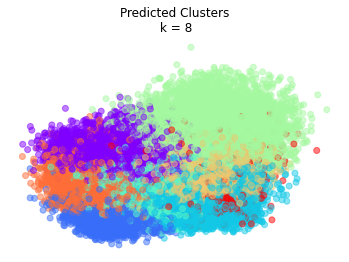

In [150]:
#Plot the data points, colored based on which cluster they belong to
colors = list(plt.cm.rainbow(np.linspace(0,1, numClusters)))
colors_p = [colors[l] for l in km.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_ai[:, 0], reducedPCA_ai[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numClusters))
plt.show()

In [151]:
#Add the predictions to the DataFrame for reference
df['kmeans_predictions'] = km.labels_

In [136]:
#Function to make silhouette plots
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    
    ax2.scatter(reducedPCA_ai[:, 0], reducedPCA_ai[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                color=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = aiPCA.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

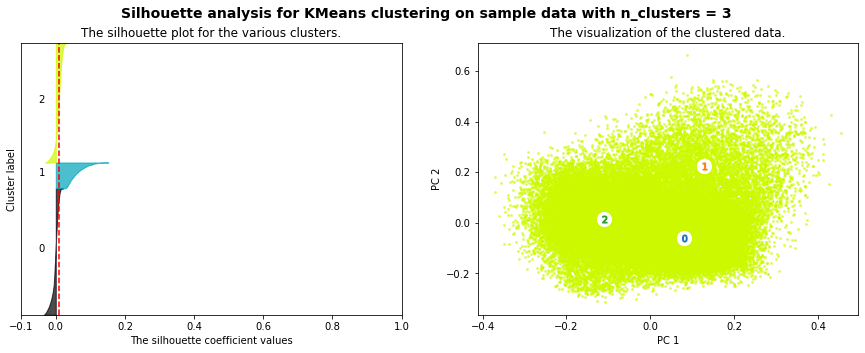

For n_clusters = 3, The average silhouette_score is : 0.008


In [137]:
#The following cells display silhouette plots.
X = aiTFVects.toarray()
plotSilhouette(3, X)

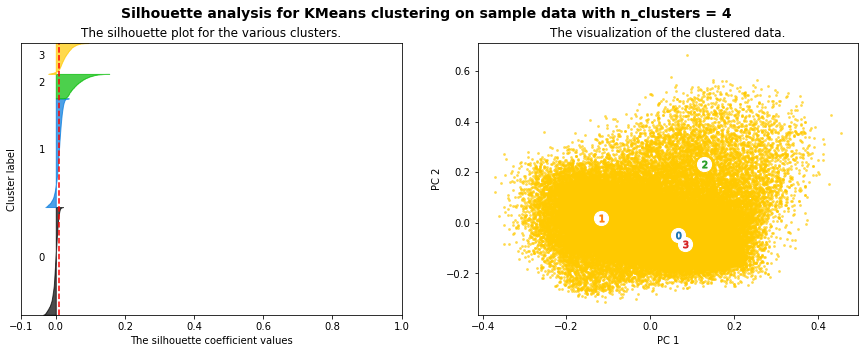

For n_clusters = 4, The average silhouette_score is : 0.010


In [138]:
plotSilhouette(4, X)

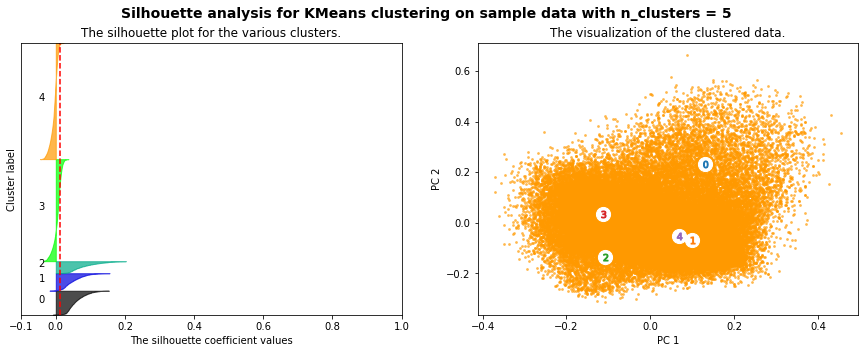

For n_clusters = 5, The average silhouette_score is : 0.011


In [139]:
plotSilhouette(5, X)

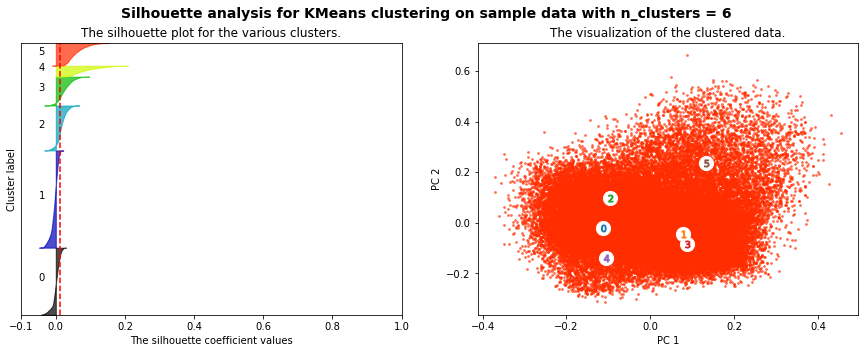

For n_clusters = 6, The average silhouette_score is : 0.012


In [140]:
plotSilhouette(6, X)

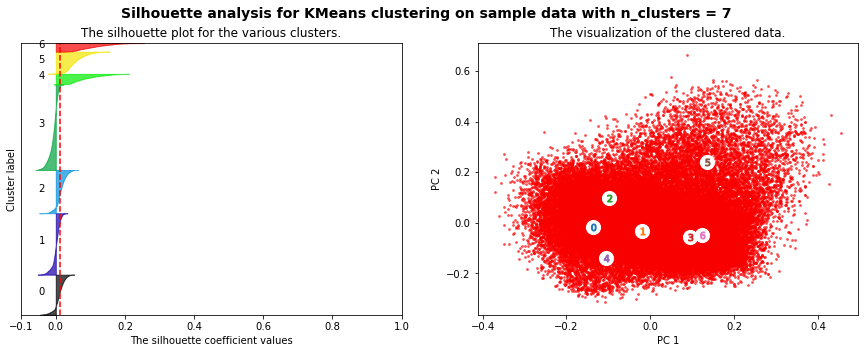

For n_clusters = 7, The average silhouette_score is : 0.012


In [141]:
plotSilhouette(7, X)

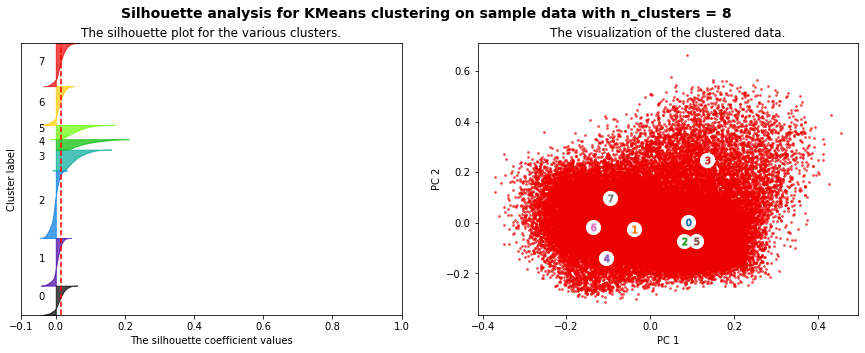

For n_clusters = 8, The average silhouette_score is : 0.015


In [142]:
plotSilhouette(8, X)

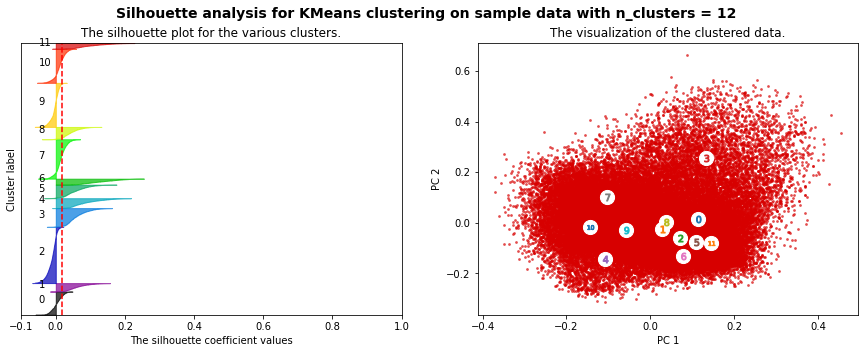

For n_clusters = 12, The average silhouette_score is : 0.019


In [144]:
plotSilhouette(12, X)

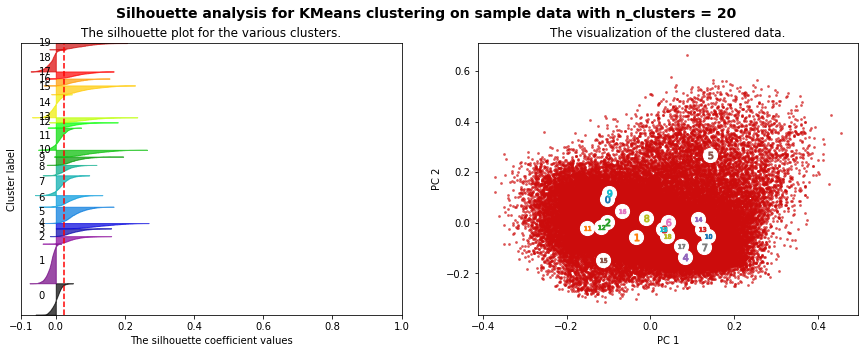

For n_clusters = 20, The average silhouette_score is : 0.025


In [152]:
plotSilhouette(20, X)

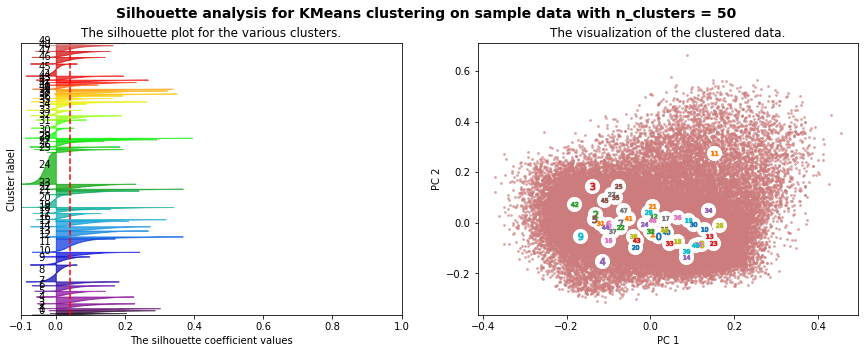

For n_clusters = 50, The average silhouette_score is : 0.041


In [153]:
plotSilhouette(50, X)

The clusters still do not seem very meaningful and the silhouette scores are quite low. We can notice some trends in the word lists–most clearly, the first 6 words in Cluster 4 are closely related to China and US-China government relations. One issue here is that we have a wide range of publishers in the NOW corpus and they often write about the same topics with similar language. It is not like, say, "subreddits" where discourse is neatly partitioned.

What about topic models?

In [154]:
dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])

In [155]:
corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]

In [159]:
gensim.corpora.MmCorpus.serialize('ai.mm', corpus)
aimm = gensim.corpora.MmCorpus('ai.mm')

In [160]:
ailda = gensim.models.ldamodel.LdaModel(corpus=aimm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [161]:
ai1Bow = dictionary.doc2bow(df['reduced_tokens'][0])
ai1lda = ailda[ai1Bow]
print("The topics of the text: {}".format(df['title'][0]))
print("are: {}".format(ai1lda))

The topics of the text: Grandmasters and Global Growth
are: [(0, 0.27133775), (1, 0.05170759), (2, 0.29531765), (3, 0.050831117), (8, 0.32839972)]


In [162]:
ldaDF = pd.DataFrame({
        'title' : df['title'],
        'topics' : [ailda[dictionary.doc2bow(l)] for l in df['reduced_tokens']]
    })

In [164]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['title']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
#ldaDFVis = ldaDFV.as_matrix(columns=None)
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.271346,0.05171,0.29532,0.050802,0.000000,0.000000,0.000000,0.000000,0.328417,0.000000
1,0.156686,0.00000,0.00000,0.000000,0.147834,0.116250,0.092762,0.041757,0.267147,0.176224
2,0.647443,0.00000,0.00000,0.033861,0.051913,0.047534,0.091033,0.042443,0.085443,0.000000
3,0.453793,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.543902,0.000000
4,0.284526,0.00000,0.00000,0.150369,0.000000,0.000000,0.000000,0.458722,0.091148,0.000000
5,0.375258,0.00000,0.00000,0.257620,0.000000,0.000000,0.077188,0.281385,0.000000,0.000000
6,0.440743,0.00000,0.00000,0.498195,0.000000,0.000000,0.000000,0.000000,0.047587,0.000000
7,0.000000,0.00000,0.00000,0.302621,0.000000,0.000000,0.153092,0.213564,0.319032,0.000000
8,0.383824,0.00000,0.00000,0.189340,0.315851,0.028489,0.000000,0.016074,0.063320,0.000000
9,0.185562,0.00000,0.00000,0.232312,0.268792,0.000000,0.000000,0.181831,0.118575,0.000000


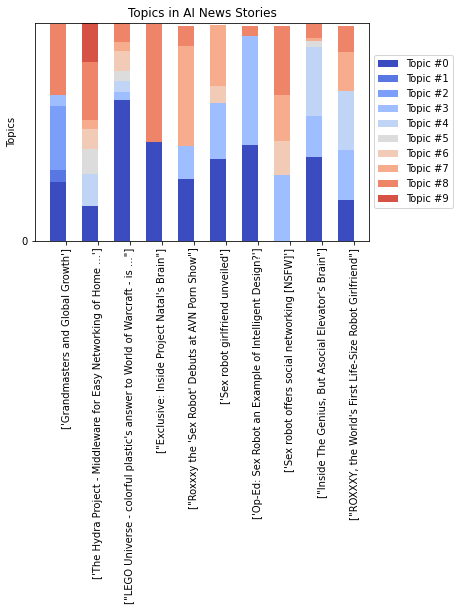

In [165]:
N = 10
ind = np.arange(N)
K = ailda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in AI News Stories')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [167]:
topicsDict = {}
for topicNum in range(ailda.num_topics):
    topicWords = [w for w, p in ailda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,think,china,say,human,vehicle,business,company,say,learn,health
1,people,market,government,say,car,company,year,people,machine,patient
2,game,chinese,year,robot,drive,customer,app,facebook,model,study
3,year,company,country,work,autonomous,market,google,social,work,image
4,work,coronavirus,work,job,nvidia,service,market,content,science,test
5,know,trade,global,people,energy,cloud,apple,company,algorithm,model
6,come,year,india,law,power,digital,share,news,computer,research
7,way,global,sector,police,say,solution,stock,information,process,disease
8,thing,say,economy,automation,intel,industry,product,user,network,high
9,look,country,business,future,air,platform,say,video,build,base


These make more sense! Topic_0 has something to do with knowledge, gaming, and design. Topic_1 is China and international trade. Topic_2 and Topic_3 are more generic, then Topic_4 is autonomous cars and energy, and Topic_5 is business and marketing. Again we see that this is in general a very business-oriented corpus. There are not many technical topics (e.g. machine learning techniques) or social topics (e.g. bias or social impact).

Now the moment of truth. Can we see changes in topics over time, using a structural topic model? Because of how computationally demanding this is, let's do a smaller DataFrame first.

In [188]:
shortNumber = 100

In [197]:
dfs = {}

for i in range(10,22):
    dfs[i] = df[df['year'] == i][:shortNumber]

In [207]:
dfShort = pd.DataFrame()

for key in dfs:
    dfShort = dfShort.append(dfs[key])

In [209]:
shortDictionary = gensim.corpora.Dictionary(dfShort['reduced_tokens'])

In [210]:
shortCorpus = [shortDictionary.doc2bow(text) for text in dfShort['reduced_tokens']]

In [211]:
gensim.corpora.MmCorpus.serialize('aiShort.mm', shortCorpus)

In [212]:
aiShortCorpus = gensim.corpora.MmCorpus('aiShort.mm')

In [213]:
from gensim.models import ldaseqmodel

In [214]:
short_slice = [shortNumber] * 11

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=aiShortCorpus, id2word=shortDictionary, time_slice=short_slice, num_topics=4)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
df[df['text'] == ""]
df

In [ ]:
df[df['text'].isnull()]
df

In [ ]:
ldaseq.print_topics(time=0)

In [ ]:
ldaseq.print_topics(time=1)

In [ ]:
ldaseq.print_topics(time=2)

Now, with the full DataFrame.

In [ ]:
docs_per_time_slice = np.flip(df['year'].value_counts().to_numpy())

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]